In [7]:
from process_data import SerialData
from pathlib import Path
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.fft as fft
import control

PROJECT_BASE = Path(os.path.abspath('')).parents[1]
DATA_FILE = PROJECT_BASE / 'src' / 'processing' / 'data' / 'swept_sine_0_9.txt'

# load recorded data from file
data = SerialData(str(DATA_FILE))

ValueError: x and y must have same first dimension, but have shapes (12582,) and (0,)

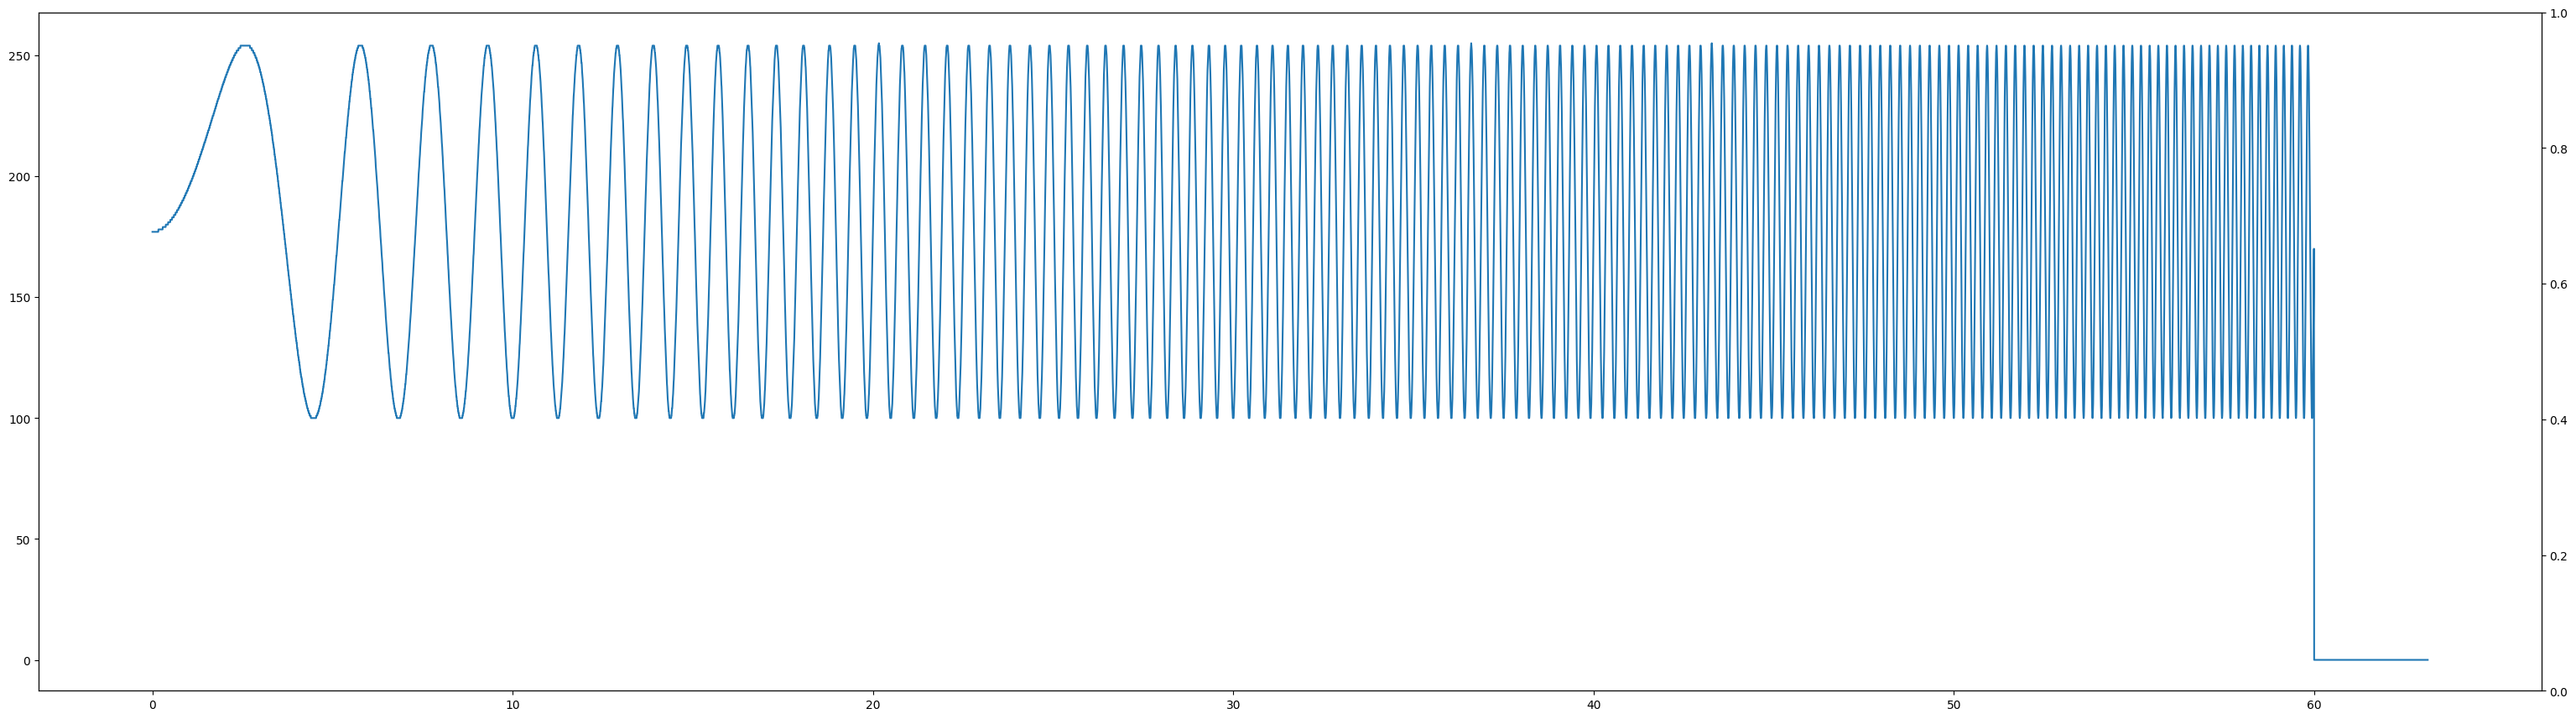

In [ ]:
# get times, speeds, pwm commands from data
times = np.array(data.times) / 1000.0
commands = np.array(data.pwmSpeeds)
speeds = np.array(data.vehSpeeds)

def roll_mean(values, window=5):
    filt_values = np.copy(values)
    for i in range(len(values)):
        if i < window or i > len(values) - window - 1: continue
        sum = 0
        for j in range(-window, window + 1):
            sum += (values[i+j])
        filt_values[i] = sum / (2 * window + 1)
    return filt_values

# filter linear speeds to get rid of weird noise. it's noncausal, so we're not introducing any filter lag :)
speeds_filt = roll_mean(speeds, 15)

fig, ax = plt.subplots(1, 1, sharex=True)
fig.set_size_inches(38.5, 10.5, forward=True)
ax2 = ax.twinx()
ax.plot(times, commands, label="PWM Output Commands (0-255)")
ax2.plot(times, speeds, label="Linear Speed (m/s)", color='red')
ax2.plot(times, speeds_filt, label="Linear Speed Filtered (m/s)", color='green', zorder=999)
ax.legend()
ax2.legend()

In [ ]:
# from plot above, looking like ~2 seconds to 40 seconds is pretty good data. Anything higher frequency seems to be pretty inconsistent...

times_crop = times[(times >= 2.0) & (times <= 60.0)]
commands_crop = commands[(times >= 2.0) & (times <= 60.0)]
speeds_crop = speeds_filt[(times >= 2.0) & (times <= 60.0)]

fig, ax = plt.subplots(1, 1, sharex=True)
fig.set_size_inches(38.5, 10.5, forward=True)
ax2 = ax.twinx()
ax.plot(times_crop, commands_crop, label="PWM Output Commands (0-255)")
ax2.plot(times_crop, speeds_crop, label="Linear Speed Filtered (m/s)", color='red')
ax.legend()
ax2.legend()

NameError: name 'speeds_filt' is not defined

In [4]:
# taking fourier transforms
N = commands_crop.size
timestep = 0.005

# get frequency domain
freq = fft.fftfreq(N, d=timestep)

# get fourier transform of commands and speeds
commands_fft = np.abs(fft.fft(commands_crop))
speeds_fft = np.abs(fft.fft(speeds_crop))

# get ratio of absolute value of output over input, normalize by max gain over interval [0, 4]
gains_fft = speeds_fft / commands_fft
gains_fft_crop = gains_fft[(freq > 0) & (freq < 4)]
gains_fft_norm_crop = gains_fft[(freq > 0) & (freq < 4)] / np.max(gains_fft[(freq > 0) & (freq < 4)])
freq_crop = freq[(freq > 0) & (freq < 4)]

plt.plot(freq_crop, gains_fft_norm_crop, label="Ouput/Input", color='red')
plt.legend()
plt.xlim(0, 4)
plt.ylim(0, 1)

fig = plt.gcf()
fig.set_size_inches(38.5, 10.5, forward=True)

NameError: name 'speeds_crop' is not defined

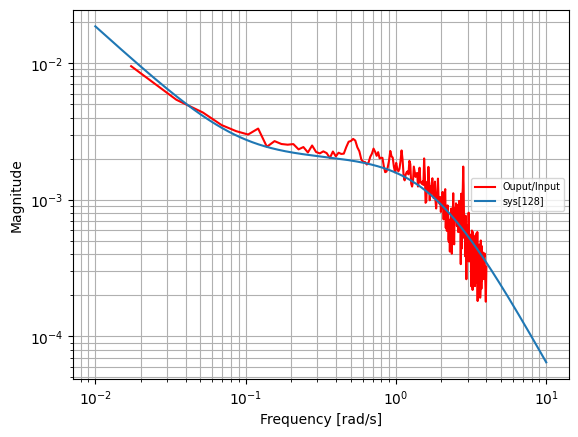

In [218]:
fig, ax = plt.subplots(1)

ax.plot(freq_crop, gains_fft_crop, label="Ouput/Input", color='red')
ax.legend()
# ax.set_yscale('log')
ax.set_xscale('log')
ax.grid()
# fig.set_size_inches(38.5, 10.5, forward=True)

# gain = 1/255
# zeta = 1.1
# omega_n = 0.3

K = 1.7/255
D3 = 1
D2 = -2*1.8
D1 = 1.8 ** 2
D0 = 0

emp_tf = control.tf([K, -0.09*K],[1, D2, D1, D0])

control.bode_plot(emp_tf, ax=ax, plot_phase=False)

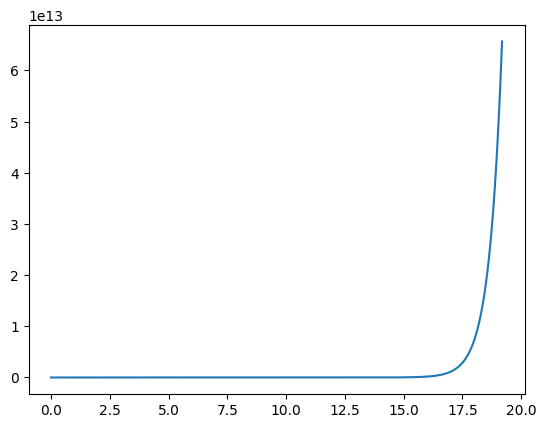

In [222]:
T, Y = control.step_response(emp_tf)
plt.plot(T, Y)